In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow import keras 

# Run in anaconda prompt first:
# conda install -c conda-forge librosa
import librosa
import librosa.display
import librosa.feature

#from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
# Make sure you have the following files in the same directory as this ipynb:
# 1. nsynth-test.tfrecord
# 2. nsynth-train.tfrecord
# 3. nsynth-valid.tfrecord

nsynth_test = tf.data.TFRecordDataset(['nsynth-test.tfrecord'], num_parallel_reads=2)
nsynth_train = tf.data.TFRecordDataset(['nsynth-train.tfrecord'], num_parallel_reads=2)

In [3]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#read_the_tfrecord_file

def get_features(record):
    # We're only going to use a few features for now
    features = {
        # identifier string, this will be our label
        #"note_str": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        # MIDI tuning standard value for pitch
        "pitch": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        # list of normalized audio 'samples' to represent the sound wave
        "audio": tf.io.FixedLenFeature(shape=[64000], dtype=tf.float32)
    }
    sample = tf.io.parse_single_example(record, features)
    
    return sample

In [4]:
test_ds = list(nsynth_test.take(1000).map(get_features))

In [5]:
# Note about how our audio feature is structured:
#
# 4 seconds * 16000 samples per second = 64000 samples
# We only have one channel (these sound clips are mono)
# Dynamic range of 16-bit PCM WAV (-2^15, 2^15 - 1) normalized to (-1, 1)


# We get the first sample in our test dataset as an example
clip1 = test_ds[0]['audio']

C:\Users\flamestormp\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\flamestormp\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


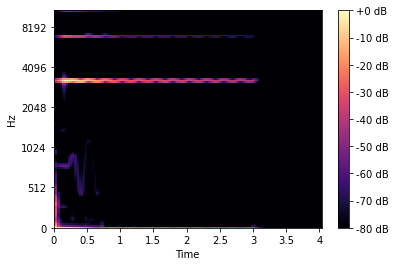

In [6]:
# A mel spectrogram. A spectrogram visualizes a signal's amplitude at different 
# frequencies over time. The mel scale is used because human perception of pitch
# is not linear. We use the mel scale because we want to retrieve the 
# Mel-frequency Cepstral Coefficients (MFCCs).
sample_rate = 16000
S = librosa.feature.melspectrogram(np.array(clip1), sr=sample_rate, n_fft=2048, hop_length=512)

# amplitude to decibels, relative to maximum value in audio clip
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

(13, 126)

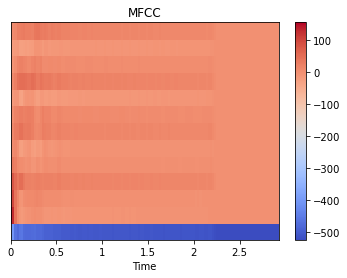

In [7]:
# try getting mfccs with librosa, see below for tensorflow version

MFCC = librosa.feature.mfcc(np.array(clip1), sr=sample_rate, n_mfcc=13)
fig, ax = plt.subplots()
img = librosa.display.specshow(MFCC, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
MFCC.shape

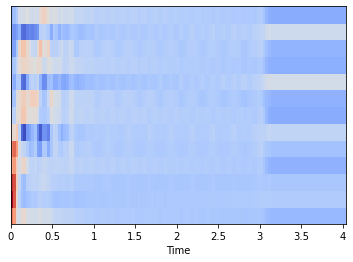

In [22]:
# scaled mfccs
from sklearn import preprocessing as pre

MFCC = pre.scale(MFCC, axis=1)
librosa.display.specshow(MFCC, sr=sample_rate, x_axis='time')

In [9]:
# temporarily borrowing code just for demonstration purposes

def midi_pitch_to_frequency(d):
    return (2**((d-69)/12.0))*440.0

from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def frequency_to_note(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

def midi_pitch_to_note(d):
    return frequency_to_note(midi_pitch_to_frequency(d))

f = midi_pitch_to_frequency(100)
print("Frequency: ", f)
print("Note: ", frequency_to_note(f))

Frequency:  2637.02045530296
Note:  E7


In [10]:
test_note = test_ds[0]['pitch']
test_note
# We can observe a few things from the previous 3 results:

# 1. Our first audio clip has midi pitch value 100, which encodes the note E7. 
# 2. The note E7 has the fundamental frequency 2637 Hz.
# 3. The spectogram above has frequency ~2700 Hz most represented.

<tf.Tensor: shape=(), dtype=int64, numpy=100>

In [11]:
# https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms
# https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

def to_mfccs(audio_array):
    return librosa.feature.mfcc(audio_array, sr=sample_rate, n_mfcc=40).flatten()

"""
def manual_convert_to_mfccs(audio_tensor):
    sample_rate = 16000
    # A 1024-point STFT with frames of 64 ms and 75% overlap.
    stfts = tf.signal.stft(audio_tensor, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)

    # convert spectrograms to mel-scale
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    # most researchers use 13-20 cepstral coefficients for speech recognition
    # we'll start with that for now (to reduce feature space)
    num_mfcc = 20
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfcc] 
    
    # flatten 2D tensor
    return tf.reshape(mfccs, [-1])

clip1_mfccs = convert_to_mfccs(clip1)
clip1_mfccs
"""
# result: we go from 64,000 samples to 247x20 coefficients. 
# huge reduction in feature space!

<tf.Tensor: shape=(4940,), dtype=float32, numpy=
array([-5.54877434e+01,  1.22019005e+01,  6.14830875e+00, ...,
       -9.17370990e-03,  8.79557896e-03, -8.42745509e-03], dtype=float32)>

In [13]:
# Trim 289,205 training samples down to 20,000
# Too many samples takes too long to load and uses a lot of RAM
train_ds = list(nsynth_train.take(10000).map(get_features))

In [14]:

# We trimmed 4096 test samples down to 1000 
y_test = [test_ds[i]['pitch'].numpy() for i in range(len(test_ds))]
x_test = [to_mfccs(test_ds[i]['audio'].numpy()) for i in range(len(test_ds))]
#x_test = [convert_to_mfccs(test_ds[i]['audio']).numpy() for i in range(len(test_ds))]

y_train = [train_ds[i]['pitch'].numpy() for i in range(len(train_ds))]
x_train = [to_mfccs(train_ds[i]['audio'].numpy()) for i in range(len(train_ds))]
#x_train = [convert_to_mfccs(train_ds[i]['audio']).numpy() for i in range(len(train_ds))]

In [15]:
#pca = PCA(n_components=100) #size of feature space => 100 dimensions
#pca_x_test = pca.fit_transform(x_test)
#pca_x_train = pca.fit_transform(x_train)

In [16]:
svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_y_predict = svm_clf.predict(x_test)

In [26]:
#from sklearn.metrics import confusion_matrix, classification_report

#svm_cm = confusion_matrix(y_test, svm_y_predict)
#mycolumns = ["Target: " + midi_pitch_to_note(i) for i in range(10,108)]
#myindices = ["Predict: " + midi_pitch_to_note(i) for i in range(10,108)]
#svm_cm_df = pd.DataFrame(svm_cm, index=myindices, columns=mycolumns)
#svm_cm_df

,Target: A#-1,Target: B-1,Target: C0,Target: C#0,Target: D0,Target: D#0,Target: E0,Target: F0,Target: F#0,Target: G0,...,Target: D7,Target: D#7,Target: E7,Target: F7,Target: F#7,Target: G7,Target: G#7,Target: A7,Target: A#7,Target: B7
Predict: A#-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: B-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: C0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: C#0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: D0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Predict: G7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,10,0,0,1,0
Predict: G#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,2,0
Predict: A7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,2,0
Predict: A#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0


In [25]:
print(classification_report(y_test, svm_y_predict))

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.04      0.60      0.07        10
          22       0.00      0.00      0.00         8
          23       0.00      0.00      0.00        12
          24       0.00      0.00      0.00         7
          25       0.00      0.00      0.00         6
          26       0.00      0.00      0.00         9
          27       0.00      0.00      0.00        11
          28       0.00    

### Notes (version 11/18/2020)

**Experiment 1:**
- runtime was about 6 minutes (~2 minutes to load and process data, ~4 minutes to fit SVM)
- used 20 mfcc coefficients (librosa version) and 10,000 training samples
- no PCA
- accuracy is reported to be 34%
- _Conclusion: extracting MFCCs as features cuts down runtime significantly with best accuracy seen so far_

**Experiment 2:**
- runtime was about 12 minutes (~3 minutes to load and process data, ~9 minutes to fit SVM)
- used 13 mfcc coefficients (librosa version) and 20,000 training samples
- no PCA
- accuracy is reported to be 19%
- _Conclusion: it appears that more coefficients is better than more data, training is main bottleneck._

**Experiment 3:**
- runtime was about 17 minutes (~3 minutes to load and process data, ~14 minutes to fit SVM)
- used 20 mfcc coefficients (librosa version) and 20,000 training samples
- no PCA
- accuracy is reported to be 38%
- _Conclusion: only a bit better than experiment 1 despite more than twice the runtime._

**Experiment 4:**
- runtime was about 9 minutes (~2 minutes to load and process data, ~7 minutes to fit SVM)
- used 40 mfcc coefficients (librosa version) and 10,000 training samples
- no PCA
- accuracy is reported to be 54%
- _Conclusion: Indeed, increasing coefficients has a greater effect on accuracy. Runtime doesn't even scale up that much._